In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = ""
CHAPTER_ID = ""

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [3]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [4]:
import gym
import math
from time import sleep
env=gym.make('gym_lex:lex-v0')
env.theta_threshold_radians = 44 * 2 * math.pi / 360
#env.x_threshold=0.4
print(env.theta_threshold_radians)
print(env.x_threshold)

0.767944870877505
2.4


**hard-coded policy

In [5]:
frames = []
action=0
for i_episode in range(1):
    observation = env.reset()
    for t in range(1000):
        img = env.render(mode="rgb_array")
        frames.append(img)
        position, velocity, angle, angular_velocity = observation
        if angular_velocity<0:
            action = 0
        else:
            action = 1
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 200 timesteps


<IPython.core.display.Javascript object>


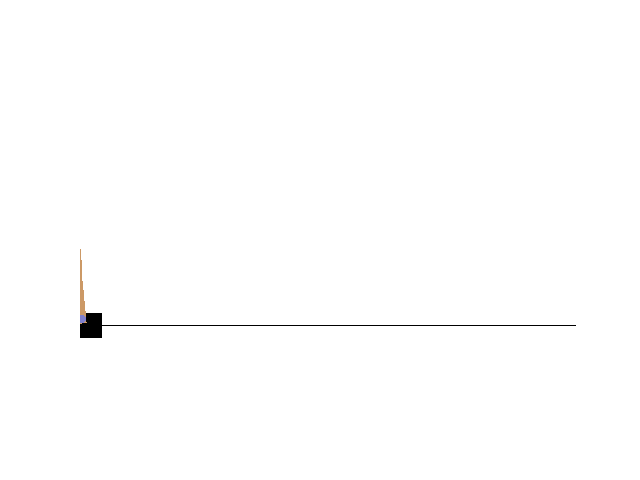

In [6]:
video = plot_animation(frames)
plt.show()

**Neural Network Policies

In [10]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
n_environments = 10
n_iterations = 1000

#envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
envs = [gym.make("gym_lex:lex-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [26]:
def render_policy_net(model_path, action, X, n_max_steps):
    frames = []
    #env = gym.make("CartPole-v0")
    env = gym.make("gym_lex:lex-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


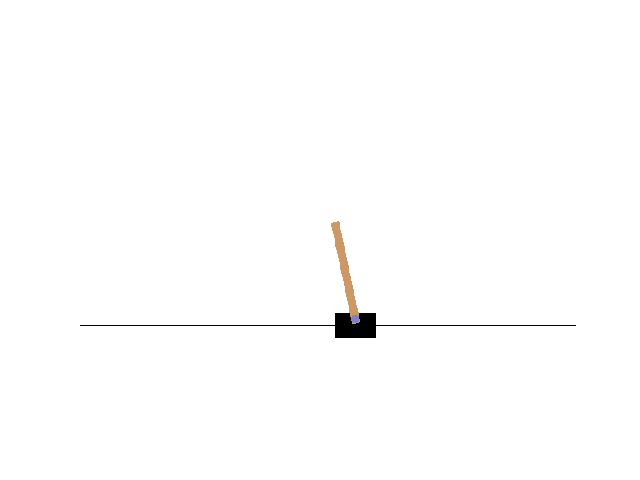

In [13]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()

**Policy Gradients

In [14]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [16]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [17]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [21]:
env=gym.make('gym_lex:lex-v0')
env.theta_threshold_radians = 22 * 2 * math.pi / 360

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 2500
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 2499

In [22]:
env.close()

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


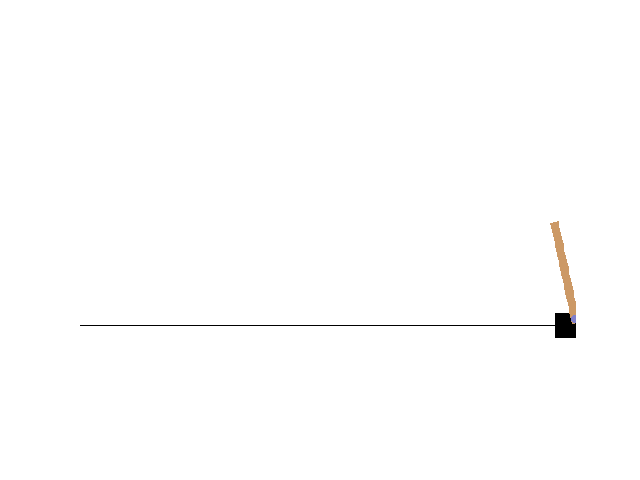

In [27]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=10000)
video = plot_animation(frames)
plt.show()